# Hierarchical risk parity para la optimizacion de portafolios

# 1. Definir el problema

El objetivo es maximizar el retorno ajustado por riesgo de una cartera. Se utilizara algoritmos de clustering para definir las asignaciones de capital a los diferentes instrumentos.

El uso del clustering se dara en el contexto de la metodologia de *Hierarchical Risk Parity (HRP)* que consta de los siguientes pasos:

- **Tree clustering:** Agrupar los instrumentos basado en la matriz de correlacion.

- **Quasi-diagonalization:** Reorganizar la matriz de covarianzas de manera que instrumentos similares esten juntos y que los mayores valores esten en la diagonal.

- **Recursive bisection:** Distribuir los pesos del portafolio de manera inversamente proporcional a las varianzas agregadas (*inverse variance allocation*).

# 2. Cargar herramientas y data

## Paquetes de Python

In [1]:
# trabajo con tablas y visualizacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

# clustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

# mean-variance optimization
import cvxopt as opt # installar en terminal (pip instal cvxopt)
from cvxopt import blas, solvers
import hrp


## Cargar la data

In [2]:
raw_data = read_csv('inputs/sp500_closes.csv', index_col=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 3. Exploracion de datos

In [4]:
dataset = raw_data.copy()
dataset = dataset.sort_index(ascending=True)
dataset.head()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


In [5]:
dataset.shape

(448, 502)

# 3. Preparacion de la data

## Misings
Haremos un check de `NA`s en las filas. Las alternativas son eliminar o imputar estas observaciones.

In [6]:
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [7]:
proporcion_missing = dataset.isnull().mean().sortvalues(ascending=False)
proporcion_missing.head(10)

CTVA    0.781250
DOW     0.678571
FOX     0.667411
FOXA    0.665179
NOV     0.000000
MSI     0.000000
MSCI    0.000000
MYL     0.000000
NDAQ    0.000000
ABT     0.000000
dtype: float64

In [8]:
cond = proporcion_missing > 0.3
drop_list = list(proporcion_missing.loc[cond].index)
drop_list

['CTVA', 'DOW', 'FOX', 'FOXA']

In [9]:
dataset = dataset.drop(labels=drop_list, axis=1)
dataset.shape

(448, 498)

Imputacion practica de missings (si hubiera) para data de alta frecuencia: el valr del periodo anterior.

In [10]:
dataset = dataset.fillna(method='ffill')

## Train-test split

In [11]:
X = dataset.copy()
n_filas = len(X)
train_len = int(n_filas*.8)

In [12]:
X_train = X.head(train_len)
X_test = X.tail(n_filas-train_len)

## Generar retornos

No nos interesan los precios, sino los cambios en estos (que son la fuente de rentabilidad). Para esto debemos generar *vectores de retornos*. Estos retornos tambien seran la base asignacionde pesos y la evaluacion (*backtesting* fuera de muestra).

In [32]:
dataset.loc[0, "ABT"]

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.980000,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.550000,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.120000,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.880000,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.280000,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07,81.040001,74.330002,164.429993,186.809998,55.410000,276.899994,28.930000,158.270004,15.85,74.830002,...,187.589996,107.019997,64.279999,29.830000,92.629997,75.570000,113.690002,134.500000,43.439999,126.070000
2019-10-08,78.510002,73.529999,159.490005,182.199997,54.130001,270.829987,28.230000,154.330002,15.51,71.800003,...,184.360001,102.570000,63.590000,28.309999,89.269997,73.430000,112.589996,131.220001,42.209999,125.379997
2019-10-09,79.500000,73.300003,159.309998,184.339996,53.430000,274.269989,28.459999,154.410004,15.54,72.250000,...,186.199997,104.419998,63.919998,28.760000,90.480003,74.570000,113.330002,133.419998,42.419998,126.430000


In [38]:
a = dataset.loc["2018-01-02", "ABT"]

In [39]:
b = dataset.loc["2018-01-03", "ABT"]

In [41]:
b/a-1

0.0022112136654794945

In [42]:
dataset.pct_change()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.002211,0.015649,0.017300,0.004615,0.015550,0.018796,0.051913,0.009049,-0.000919,-0.004531,...,0.018709,-0.010834,-0.006693,-0.001362,0.020035,0.012193,-0.000858,0.006932,-0.001183,0.004598
2018-01-04,-0.001697,-0.005703,0.017516,0.011841,-0.009952,0.012042,0.049351,0.036899,-0.003680,-0.017712,...,0.010151,0.005415,-0.007791,0.012274,0.018053,0.006676,0.010180,-0.001441,0.004147,0.005964
2018-01-05,0.002890,0.017408,0.015408,0.008249,0.026446,0.011571,-0.019802,0.010631,0.003693,0.004684,...,0.006413,0.006671,-0.007003,0.007410,0.051922,-0.001874,0.005828,0.009941,0.000393,0.011444
2018-01-08,-0.002882,-0.016022,0.027086,0.007991,0.003917,-0.001619,0.033670,-0.007042,0.000000,0.005314,...,-0.005387,-0.013314,0.007480,0.011702,0.006608,0.003611,0.001690,0.001905,-0.004914,0.011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07,-0.011587,-0.004420,-0.028479,-0.014923,-0.000541,-0.000217,-0.002758,-0.010441,-0.011229,-0.021446,...,-0.005619,-0.017354,-0.005415,0.008111,-0.017084,-0.005265,-0.008460,0.000372,0.005556,-0.007714
2019-10-08,-0.031219,-0.010763,-0.030043,-0.024677,-0.023101,-0.021921,-0.024196,-0.024894,-0.021451,-0.040492,...,-0.017218,-0.041581,-0.010734,-0.050955,-0.036273,-0.028318,-0.009675,-0.024387,-0.028315,-0.005473
2019-10-09,0.012610,-0.003128,-0.001129,0.011745,-0.012932,0.012702,0.008147,0.000518,0.001934,0.006267,...,0.009980,0.018036,0.005189,0.015895,0.013554,0.015525,0.006573,0.016766,0.004975,0.008375


In [13]:
returns = X_train.pct_change().dropna()
returns_test = X_test.pct_change().dropna()

# 4. Aplicar algoritmo

## Agglomerative hierarchical clustering

Buscaremos grupos de correlaciones utilizando *agglomerative hierarchical clustering*. Primero inspeccionemos las correlaciones entre activos.

In [14]:
correlations = returns.corr()

In [15]:
correlations

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
ABT,1.000000,0.494779,0.559888,0.619775,0.397699,0.615525,0.427044,0.262130,0.301772,0.471728,...,0.449084,0.302715,0.167765,0.366391,0.428237,0.523841,0.512067,0.630558,0.386199,0.633494
ABBV,0.494779,1.000000,0.328560,0.448563,0.227356,0.373120,0.249351,0.245793,0.218430,0.355847,...,0.324832,0.175763,0.126282,0.238749,0.237091,0.345308,0.295614,0.416966,0.338153,0.458783
ABMD,0.559888,0.328560,1.000000,0.442537,0.348544,0.538888,0.404483,0.214187,0.167113,0.325449,...,0.266271,0.281851,-0.046713,0.259675,0.265147,0.367287,0.367727,0.383832,0.275702,0.477099
ACN,0.619775,0.448563,0.442537,1.000000,0.434381,0.639643,0.379175,0.342644,0.312982,0.493182,...,0.471737,0.336110,0.094066,0.434254,0.469976,0.529361,0.494324,0.514715,0.467125,0.609324
ATVI,0.397699,0.227356,0.348544,0.434381,1.000000,0.539612,0.345760,0.235849,0.177897,0.359480,...,0.179086,0.254205,-0.066999,0.239170,0.349106,0.260986,0.285587,0.318275,0.256605,0.371386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.523841,0.345308,0.367287,0.529361,0.260986,0.490386,0.290216,0.198813,0.228458,0.532522,...,0.376416,0.383552,0.056461,0.425069,0.404543,1.000000,0.430837,0.414418,0.376027,0.586310
YUM,0.512067,0.295614,0.367727,0.494324,0.285587,0.504548,0.280794,0.233912,0.277423,0.342556,...,0.361048,0.154068,0.166228,0.422834,0.340871,0.430837,1.000000,0.400255,0.332823,0.538596
ZBH,0.630558,0.416966,0.383832,0.514715,0.318275,0.494569,0.406051,0.240855,0.293290,0.416721,...,0.387778,0.283581,0.153251,0.371157,0.381294,0.414418,0.400255,1.000000,0.402499,0.521182
ZION,0.386199,0.338153,0.275702,0.467125,0.256605,0.381552,0.239545,0.303154,0.148800,0.629731,...,0.411557,0.296437,-0.060870,0.389757,0.391890,0.376027,0.332823,0.402499,1.000000,0.389558


In [29]:
def correlDist(corr_matrix):
    """Genera una matriz de distancias a partir de una matriz de correlaciones."""
    dist = ((1 - corr_matrix) / 2) ** 0.5
    return dist

El *hierarchical clustering* tiene como output intermedio la metrica de **linkage** que cuantifica la distancia relativa entre dos puntos de la data. El output es un `array` en el que cada elemento tiene la siguiente estructura: `[intrumento_1, instrumento_2, linkage, n_obs]`

In [17]:
dist = correlDist(correlations)
link = linkage(y=dist, method='ward')

In [18]:
link[0]

array([24.        , 25.        ,  0.09110116,  2.        ])

In [31]:
link[100]

array([  3.        , 113.        ,   0.67337897,   2.        ])

Luego de calular los `links` visualizamos los clusters por medio de un *dendograma*. Interpretacion:

- **Eje X:** Las "hoja", donde cada hooja representa los instrumentos individuales. 
- **Eje Y:** La "distancia" entre *clusters*. 
- Cuanto mas largas las ramas (en el eje Y), menos correlacion entre clusters.

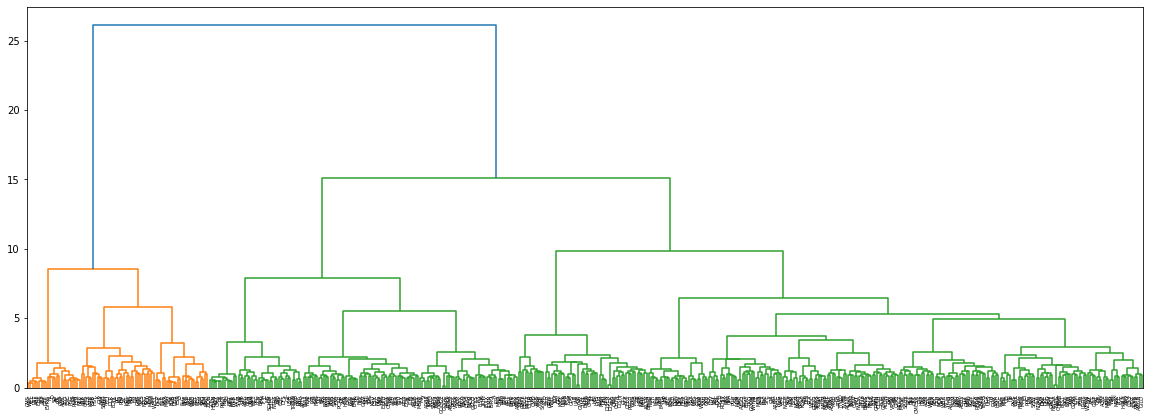

In [66]:
plt.figure(figsize=(20, 7))
dendrogram(link, labels = X.columns)
plt.show()

## Aplicar la tecnica HRP

In [67]:
from hrp import get_hrp_portfolio
portfolios = get_hrp_portfolio(returns, benchmark='mvp')

In [68]:
portfolios

,MVP,HRP
ABT,0.000039,0.001364
ABBV,0.000039,0.000967
ABMD,0.000029,0.000625
ACN,0.000050,0.001253
ATVI,0.000084,0.000696
...,...,...
XYL,0.000047,0.001129
YUM,0.000378,0.004225
ZBH,0.000052,0.001659
ZION,0.000081,0.001053


Comparemos las asignaciones MVP versus HRP:

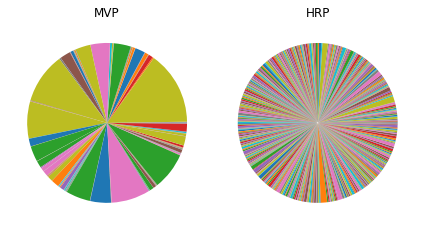

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(portfolios.iloc[:,0], )
ax1.set_title('MVP')
ax2.pie(portfolios.iloc[:,1])
ax2.set_title('HRP')
plt.tight_layout()

Puede observarse una mayor diversificacion con HRP. La prueba de fuego es que el HRP tenga un mejor performance en data no vista. Una forma de llevar a cabo este analisis es mediante el *backtesting* sobre la data de testing.

# 6. Backtesting

<AxesSubplot:title={'center':'Performance en testing'}, xlabel='Date'>

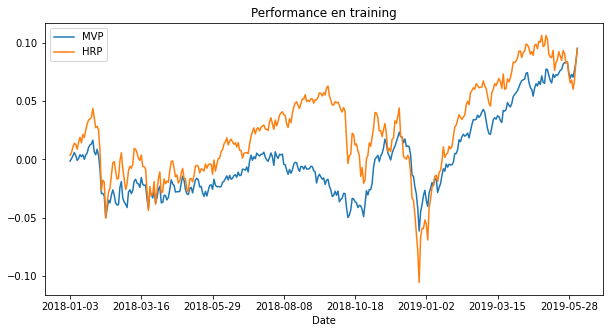

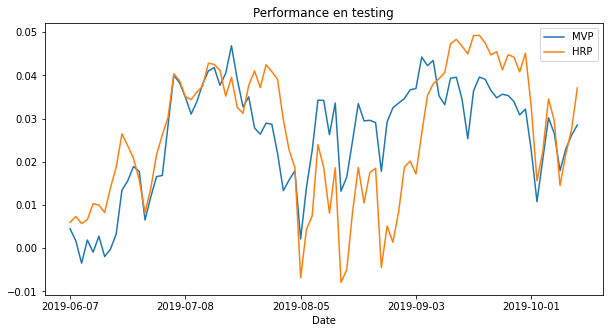

In [70]:
training_results = pd.DataFrame(np.dot(returns, np.array(portfolios)), columns=['MVP', 'HRP'], index = returns.index)
testing_results = pd.DataFrame(np.dot(returns_test, np.array(portfolios)), columns=['MVP', 'HRP'], index = returns_test.index)
training_performance.cumsum().plot(figsize=(10, 5), title ="Performance en training")
testing_performance.cumsum().plot(figsize=(10, 5), title ="Performance en testing")

## Analisis de performance anualizado

In [71]:
# training
stddev = training_results.std() * np.sqrt(252)
sharp_ratio = (training_results.mean() / (training_results).std() * np.sqrt(252)) 
results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
results

,stdev,sharp_ratio
MVP,0.085516,0.785019
HRP,0.126944,0.523599


In [72]:
# testing
stddev_oos = testing_results.std() * np.sqrt(252)
sharp_ratio_oos = (testing_results.mean() / (testing_results).std() * np.sqrt(252)) 
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.102761,0.786621
HRP,0.125610,0.836159
